In [88]:
import numpy as np
import scipy.stats as st
import warnings
import matplotlib.pyplot as plt
import sys
import scipy.integrate as integrate
import scipy.stats as st
import pandas as pd
import seaborn as sns

import OptimalSequence

In [79]:
number_samples = 380

# Generate data
### Using truncnormal 
between 0 and 20 with `mean=8`, `sigma=2`

In [3]:
upper_limit = 20
lower_limit = 0

upper_bound = (upper_limit - 8) / 2
lower_bound = (lower_limit - 8) / 2

mu = 8
sigma = 2

data = st.truncnorm.rvs(lower_bound, upper_bound, loc=8, scale=2, size=number_samples)
print("Bounds: (%3.1f %3.1f) mean=%3.1f; sigma=%3.1f" %(min(data), max(data), np.mean(data), np.std(data)))

Bounds: (1.4 13.5) mean=7.9; sigma=2.0


# Funcion to compute the cost 
### Using TOPtimal to compute the sequence

In [14]:
def compute_cost(cdf, print_sequence=False, limits = [lower_limit, upper_limit]):
    handler = OptimalSequence.TOptimalSequence(limits[0], limits[1], cdf, discret_samples=500)
    sequence = handler.compute_request_sequence()
    if sequence[-1]!=upper_limit:
        sequence[-1] = upper_limit
    arg = [lower_bound, upper_bound]
    if print_sequence:
        print(sequence)

    # Compute the expected makespan (MS)
    MS = sum([sequence[i+1]*(1-st.truncnorm.cdf(sequence[i], loc=mu, scale=sigma, *arg))
              for i in range(len(sequence)-1)])
    MS += sequence[0]
    # MS = sum([sequence[i+1]*cdf(sequence[i]) for i in range(len(sequence)-1)])
    return MS

# Fitting the data using a list of distributions

In [5]:
dist_list = [        
            st.alpha,st.beta,st.cosine,st.dgamma,st.dweibull,st.exponnorm,st.exponweib,
            st.exponpow,st.genpareto,st.gamma,st.halfnorm,st.invgauss,st.invweibull,
            st.laplace,st.loggamma,st.lognorm,st.lomax,st.maxwell,st.norm,st.pareto,
            #st.pearson3,
            st.rayleigh,st.rice,st.truncexpon,st.truncnorm,st.uniform,
            st.weibull_min,st.weibull_max
        ]

In [6]:
best_fit = [np.inf, 0, 0, 0, [0, 0, 0]]
worse_fit = [0, 0, 0, 0, [0, 0, 0]]
sys.stdout.write("[")
for i in range(100):
    data = st.truncnorm.rvs(lower_bound, upper_bound, loc=mu, scale=sigma, size=number_samples)

    # Best holders
    best_distribution = -1
    best_params = (0.0, 1.0)
    best_sse = np.inf
    best_cost = -1

    norm_distribution = []
    truncnorm_distribution = []

    # Estimate distribution parameters from data
    for distribution in dist_list:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Compute the histogram for the data
                y, x = np.histogram(data, bins=100, density=True)
                x = (x + np.roll(x, -1))[:-1] / 2.0

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                if distribution.name == "norm" or distribution.name == "truncnorm":
                    arg = params[:-2]
                    cdf = lambda val: distribution.cdf(val, loc=params[-2], scale=params[-1], *arg)
                    cost = compute_cost(cdf)
                    
                if distribution.name == "norm":
                    norm_distribution = [sse, params, cost]

                if distribution.name == "truncnorm":
                    truncnorm_distribution = [sse, params, cost]

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    arg = best_params[:-2]
    cdf = lambda val: best_distribution.cdf(val, loc=best_params[-2], scale=best_params[-1], *arg)
    best_cost = compute_cost(cdf)
            
    if np.abs(best_cost - norm_distribution[2]) < np.abs(best_fit[0] - best_fit[4][2]) and best_distribution.name != "norm":
        best_fit = [best_cost, best_sse, best_distribution, best_params, norm_distribution]
    if np.abs(best_cost - norm_distribution[2]) > np.abs(worse_fit[0] - worse_fit[4][2]):
        worse_fit = [best_cost, best_sse, best_distribution, best_params, norm_distribution]
    sys.stdout.write("=")

sys.stdout.write("]\n")

[=====================================================================================

/opt/conda/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1420: RuntimeWarning: overflow encountered in exp
  return _norm_cdf(x) - np.exp(expval) * _norm_cdf(x - invK)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1420: RuntimeWarning: invalid value encountered in multiply
  return _norm_cdf(x) - np.exp(expval) * _norm_cdf(x - invK)


===============]


# Plot data
### worse and best fit compared to the norm fit
* the best fit and 
* the norm distributions

Best fit cost 11.938229 
Norm cost 11.938229 (diff 0.000000)


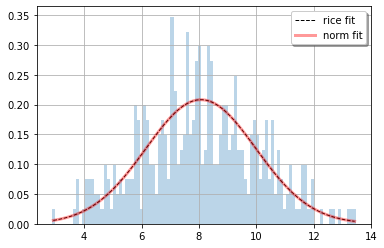

In [7]:
# Best fit

print("Best fit cost %f \nNorm cost %f (diff %f)" %(best_fit[0], best_fit[4][2], best_fit[0]-best_fit[4][2]))
fig, ax = plt.subplots(1, 1)
# plot the best fit line
best_distribution = best_fit[2]
best_params = best_fit[3]
ax.plot(x, best_distribution.pdf(x, loc=best_params[-2], scale=best_params[-1], *best_params[:-2]),
        'k--', lw=1, alpha=1.0, label='%s fit' %(best_distribution.name))
# plot the normal line
ax.plot(x, st.norm.pdf(x, *best_fit[4][1]),
        'r-', lw=3, alpha=0.4, label='norm fit')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()

Worse fit cost 19.833439 
Norm cost 11.942365 (diff 7.891074)

rice sequence:[5.48, 8.040000000000001, 10.08, 11.84, 13.44, 14.92, 16.28, 17.56, 18.8, 19.8, 19.96, 20.0]
norm sequence:[10.92, 13.6, 15.68, 17.48, 19.080000000000002, 19.96, 20.0]


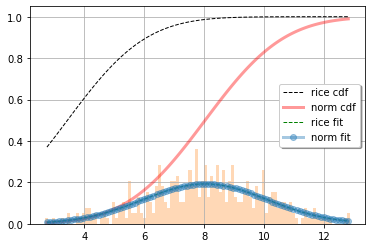

In [18]:
# Worse fit

print("Worse fit cost %f \nNorm cost %f (diff %f)\n" %(worse_fit[0], worse_fit[4][2], worse_fit[0]-worse_fit[4][2]))
worse_distribution = worse_fit[2]
worse_params = worse_fit[3]

sys.stdout.write(worse_distribution.name+" sequence:")
arg = worse_params[:-2]
cdf = lambda val: worse_distribution.cdf(val, loc=worse_params[-2], scale=worse_params[-1], *arg)
worse_cost = compute_cost(cdf, print_sequence=True)

sys.stdout.write("norm sequence:")
arg = worse_fit[4][1][:-2]
cdf = lambda val: st.norm.cdf(val, loc=worse_fit[4][1][-2], scale=worse_fit[4][1][-1], *arg)
worse_cost = compute_cost(cdf, print_sequence=True)


fig, ax = plt.subplots(1, 1)
# plot the best fit line
ax.plot(x, worse_distribution.cdf(x, loc=worse_params[-2], scale=worse_params[-1], *worse_params[:-2]),
        'k--', lw=1, alpha=1.0, label='%s cdf' %(worse_distribution.name))
# plot the normal line
ax.plot(x, st.norm.cdf(x, *worse_fit[4][1]),
        'r-', lw=3, alpha=0.4, label='norm cdf')

# plot the best fit line
ax.plot(x, worse_distribution.pdf(x, loc=worse_params[-2], scale=worse_params[-1], *worse_params[:-2]),
        'g--', lw=1, alpha=1.0, label='%s fit' %(worse_distribution.name))
# plot the normal line
ax.plot(x, st.norm.pdf(x, *worse_fit[4][1]),
        'o-', lw=3, alpha=0.4, label='norm fit')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()

# Documenting python limitations

The PDF fits the data well (close to the norm distribution), however:

### Pearson 3 distribution
When the skew parameter is negative, the CDF is decreasing from 1 to 0

### Rice distribution
In some cases, the CDF is 1 for all values

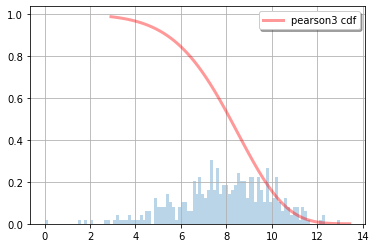

0.9993400724474001


True

In [9]:
data = st.pearson3.rvs(-0.5, loc=8, scale=2, size=number_samples)
fig, ax = plt.subplots(1, 1)
ax.plot(x, st.pearson3.cdf(x, -0.5, loc=8, scale=2),
        'r-', lw=3, alpha=0.4, label='pearson3 cdf')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()
print(st.pearson3.cdf(0, -0.5, loc=8, scale=2))
np.isclose(st.pearson3.cdf(0, -0.5, loc=8, scale=2), 1, rtol=1e-03)

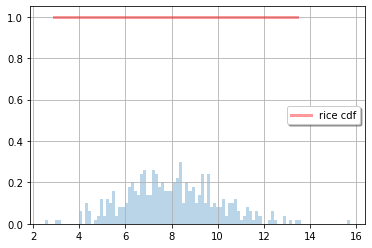

1.000000000003714


In [10]:
data = st.rice.rvs(160, loc=-312, scale=2, size=number_samples)
fig, ax = plt.subplots(1, 1)
ax.plot(x, st.rice.cdf(x, 160, loc=-312, scale=2),
        'r-', lw=3, alpha=0.4, label='rice cdf')
ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()
print(st.rice.cdf(0, 160, loc=-312, scale=2))

## Neuroscience application fit

In [83]:
def get_cdf(start, x, params):
    return integrate.quad(np.poly1d(params), start, x, epsrel=1.49e-05)[0]

In [117]:
def best_fit_distribution(data, x, y, bins, distr=[], verbose=True): 
    dist_list = distr
    if len(dist_list)==0:
        # Distributions to check
        dist_list = [        
            st.alpha,st.beta,st.cosine,st.dgamma,st.dweibull,st.exponnorm,st.exponweib,
            st.exponpow,st.genpareto,st.gamma,st.halfnorm,st.invgauss,st.invweibull,
            st.laplace,st.loggamma,st.lognorm,st.lomax,st.maxwell,st.norm,#st.pareto,
            #st.pearson3,
            st.rayleigh,#st.rice,
            st.truncexpon,st.truncnorm,st.uniform,
            st.weibull_min,st.weibull_max
        ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    progressbar_width = len(dist_list)
    if verbose:
        sys.stdout.write("[%s]" % ("." * progressbar_width))
        sys.stdout.flush()
        sys.stdout.write("\b" * (progressbar_width + 1))
    # Estimate distribution parameters from data
    for distribution in dist_list:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

        if verbose:
            sys.stdout.write("=")
            sys.stdout.flush()

    if verbose:
        sys.stdout.write("]\n")
    return (best_distribution, best_params, best_sse)

In [118]:
dataset = "FSL_First"
data = pd.Series(np.loadtxt("ACCRE/"+dataset+".out", delimiter=' '))

distribution, params, err = best_fit_distribution(data, x, y, 1000)
            
# fit a polynomial to data
y, x = np.histogram(data, bins=1000, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
best_err = np.inf
best_z = -1
for order in range(1,20):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try:
            z = np.polyfit(x, y, order)
        except:
            break

        err = np.sum((np.polyval(z, x) - y)**2)
        cdf = lambda val: get_cdf(x[0], val, best_z)
        cost = compute_cost(cdf, limits=[x[0], x[-1]])
        poly[order] = (err, cost)
        if err < best_err:
            best_order = order
            best_z = z
            best_err = err

cdf = lambda val: get_cdf(x[0], val, best_z)
cost = compute_cost(cdf, limits=[x[0], x[-1]])
print("Polynomial Order", best_order, best_z)
print("Cost", cost)

[........................=========================]
Polynomial Order 17 [ 3.13091623e-54 -8.53190412e-50  1.05839119e-45 -7.90956771e-42
  3.97148553e-38 -1.41477392e-34  3.68061109e-31 -7.09165066e-28
  1.01564576e-24 -1.07584544e-21  8.31813930e-19 -4.59013429e-16
  1.74680578e-13 -4.35192716e-11  6.53697154e-09 -5.13082070e-07
  1.55167445e-05 -4.55293700e-05]
Cost 1423.5426439999999


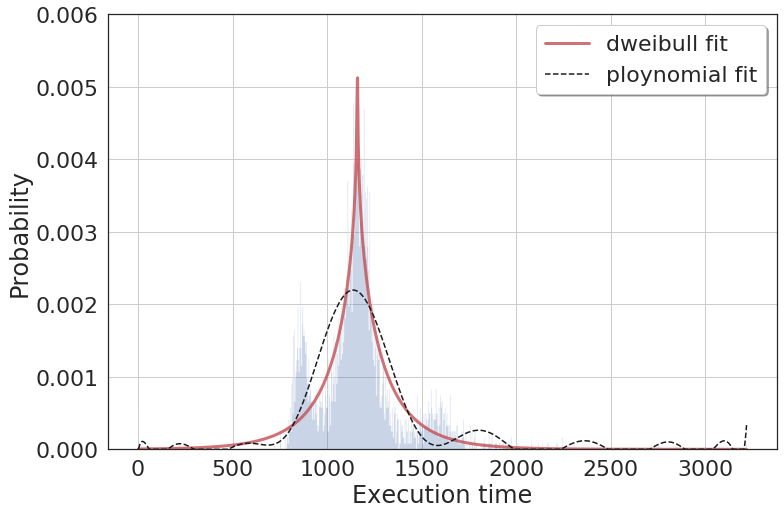

In [119]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
arg = params[:-2]
ax.plot(x, distribution.pdf(x, loc=params[-2], scale=params[-1], *arg),
        'r-', lw=3, alpha=0.8, label='%s fit' %(distribution.name))
ax.plot(x, [max(0,np.polyval(best_z, i)) for i in x], 'k--' ,label='ploynomial fit')
ax.hist(data, bins=1000, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
ax.set_ylim([0, 0.006])
plt.grid(True)
ax.set_xlabel('Execution time')
ax.set_ylabel('Probability')
plt.savefig("fit_dataset_%s.png" %(dataset))
plt.show()

## Plot the discrete and continuous fits of the data
### Gopi: "plot the cdf of discrete, and the continuity of it"

In [198]:
upper_limit = 14
lower_limit = 12

upper_bound = (upper_limit - 8) / 2
lower_bound = (lower_limit - 8) / 2
data = st.truncnorm.rvs(lower_bound, upper_bound, loc=8, scale=2, size=20)
print(data)

[13.18518271 12.36204884 12.82321184 13.21643515 12.18170921 12.53166327
 12.47461036 12.16913848 12.52602371 12.51802802 12.47901289 12.3489836
 12.00700426 12.38117999 12.28435152 12.07356796 13.09352443 12.06246746
 13.15635453 12.69311235]


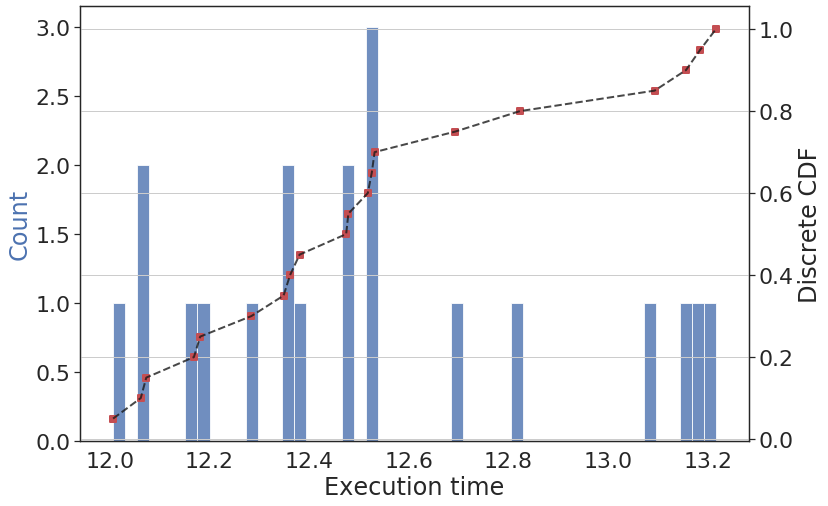

In [199]:
# compute the discrete CDF
discret_data = sorted(data)
cdf = [1 for _ in data]
todel = []
for i in range(len(data)-1):
    if discret_data[i] == discret_data[i + 1]:
        todel.append(i)
        cdf[i + 1] += cdf[i]
todel.sort(reverse=True)
for i in todel:
    del discret_data[i]
    del cdf[i]
cdf = [i*1./len(cdf) for i in cdf]
for i in range(1, len(cdf)):
    cdf[i] += cdf[i-1]
for i in range(len(cdf)):
    cdf[i] /= cdf[-1]

        
fig, ax = plt.subplots(figsize=(12,8))
sns.set(font_scale=2)
sns.set_style("white")
arg = params[:-2]
ax2 = ax.twinx()
counts, bins = np.histogram(data, bins=50)
ax.hist(bins[:-1], bins, weights=counts, alpha=0.8)
#ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.8)
ax2.plot(discret_data, cdf, 'k--', lw=2, alpha=0.8)
ax2.scatter(discret_data, cdf, marker="s", color="r", lw=2, alpha=1)
#ax.legend(shadow=True)
#ax.set_ylim([0, 0.006])
plt.grid(True)
ax.set_xlabel('Execution time')
ax2.set_ylabel('Discrete CDF')
ax.set_ylabel('Count', color="b")
plt.savefig("discrete_cdf.png")
plt.show()

# Polynomial fit

In [69]:
poly = {}
data = st.truncnorm.rvs(lower_bound, upper_bound, loc=mu, scale=sigma, size=number_samples)
y, x = np.histogram(data, bins=100, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
best_err = np.inf
best_z = -1
for order in range(1,25):
    with warnings.catch_warnings():
        warnings.simplefilter("error")
        try:
            z = np.polyfit(x, y, order)
        except:
            break

        err = np.sum((np.polyval(z, x) - y)**2)
        cdf = lambda val: get_cdf(x[0], val, best_z)
        cost = compute_cost(cdf, limits=[x[0], x[-1]])
        poly[order] = (err, cost)
        if err < best_err:
            best_order = order
            best_z = z
            best_err = err

cdf = lambda val: get_cdf(x[0], val, best_z)
cost = compute_cost(cdf, limits=[x[0], x[-1]])
print("Polynomial Order", best_order, best_z)
print("Cost", cost)

Polynomial Order 15 [-1.25075962e-09  1.49335823e-07 -8.16737138e-06  2.71157332e-04
 -6.10564096e-03  9.86733788e-02 -1.18130781e+00  1.06596869e+01
 -7.30505499e+01  3.80022423e+02 -1.48821170e+03  4.30901370e+03
 -8.93364840e+03  1.25304619e+04 -1.06438508e+04  4.13317318e+03]
Cost 11.98221349323915
-5218355.33434928


In [73]:
print(cdf(14))

0.8682482247423239


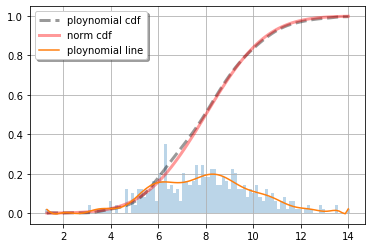

In [62]:
#print([cdf(i) for i in x])
fig, ax = plt.subplots(1, 1)
ax.plot(x, [cdf(i) for i in x], 'k--', lw=3, alpha=0.4, label='ploynomial cdf')
ax.plot(x, st.norm.cdf(x, loc=mu, scale=sigma),
        'r-', lw=3, alpha=0.4, label='norm cdf')

ax.hist(data, bins=100, density=True, histtype='stepfilled', alpha=0.3)
ax.plot(x, np.polyval(best_z, x), label='ploynomial line')
ax.legend(shadow=True)
plt.grid(True)

plt.show()

## Under and overfit of polynomials

In [63]:
poly

{1: (0.5923352005859839, 13.995450838578709),
 2: (0.23303664941723562, 13.995450838578709),
 3: (0.23059873767501507, 15.710693801503952),
 4: (0.1433073372627116, 16.897311307109494),
 5: (0.14326196126851934, 11.964342641906377),
 6: (0.1380857022068528, 11.964342641906377),
 7: (0.13808138074743215, 11.955068798964135),
 8: (0.1380591841730557, 11.955068798964135),
 9: (0.13802371737091096, 11.955068798964135),
 10: (0.1367705465989511, 11.955068798964135),
 11: (0.1363305917738076, 11.955596053546774),
 12: (0.1359200934134344, 11.955596053546774),
 13: (0.1334828594981819, 11.957989906196017),
 14: (0.13266244727903695, 11.962218917295875),
 15: (0.12995038842142065, 11.962921958166268),
 16: (0.12986420447144567, 11.96169215141158),
 17: (0.12801960295161216, 11.959477550692691)}

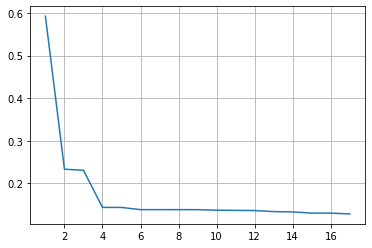

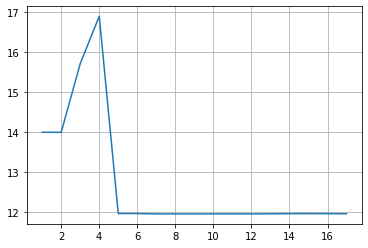

In [65]:
fig, ax = plt.subplots(1, 1)
ax.plot([i for i in poly], [poly[i][0] for i in poly])
plt.grid(True)
plt.show()
fig, ax = plt.subplots(1, 1)
ax.plot([i for i in poly], [poly[i][1] for i in poly])
plt.grid(True)
plt.show()

In [66]:
data = list(st.truncnorm.rvs(-0.5, 3, loc=0.5, scale=1, size=100)) + list(st.truncnorm.rvs(-0.75, 1.25, loc=9, scale=4, size=100))
y, x = np.histogram(data, bins=100, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0

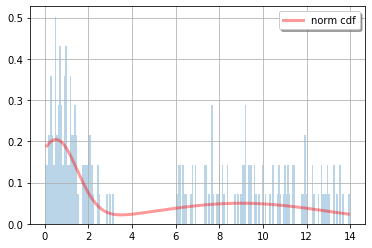

In [43]:
cdf = lambda val: (st.norm.pdf(val, loc=0.5, scale=1) + st.norm.pdf(val, loc=9, scale=4))/2
fig, ax = plt.subplots(1, 1)
ax.plot(x, [cdf(i) for i in x],
        'r-', lw=3, alpha=0.4, label='norm cdf')

ax.hist(data, bins=200, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()

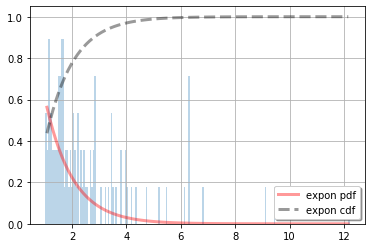

In [67]:
data = st.expon.rvs(loc=1, scale=1.5, size=100)
y, x = np.histogram(data, bins=100, density=True)
x = (x + np.roll(x, -1))[:-1] / 2.0
pdf = lambda val: st.expon.pdf(val, loc=0.5, scale=1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, [pdf(i) for i in x],
        'r-', lw=3, alpha=0.4, label='expon pdf')
ax.plot(x, st.expon.cdf(x, loc=0.5, scale=1),
        'k--', lw=3, alpha=0.4, label='expon cdf')
ax.hist(data, bins=200, density=True, histtype='stepfilled', alpha=0.3)
ax.legend(shadow=True)
plt.grid(True)

plt.show()